# **Restricted Boltzmann Machine(RBM)**

## Load the MINIST dataset :

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

BATCHSIZE = 16
VISIBLE_UNITS = 28*28
HIDDEN_UNITS = 100
CD_K = 1
EPOCHS = 40

# load datasets
tr_dataset = datasets.MNIST('data/mnist', train=True, transform=transforms.ToTensor(), download=True)
tr_loader = torch.utils.data.DataLoader(tr_dataset, batch_size=BATCHSIZE)

ts_dataset = datasets.MNIST('data/mnist', train=False, transform=transforms.ToTensor(), download=True)
ts_loader = torch.utils.data.DataLoader(ts_dataset, batch_size=BATCHSIZE)

## Define RBM model

In [2]:
class RBM():
  def __init__(self, n_visible=VISIBLE_UNITS, n_hidden=HIDDEN_UNITS, k=CD_K, lr=1e-1, momentum_rate=0.5, w_decay=1e-4):
    self.n_visible = n_visible
    self.n_hidden = n_hidden
    self.k = k
    self.lr = lr
    self.momentum_rate = momentum_rate
    self.w_decay = w_decay
  
    #self.w = torch.randn(n_visible, n_hidden) * 0.1
    self.w = torch.normal(0, 0.01, size = (n_visible, n_hidden))
    self.visible_b = torch.ones(n_visible) * 0.5
    self.hidden_b = torch.zeros(n_hidden)

    self.w_momentum = torch.zeros(n_visible, n_hidden)
    self.visible_b_momentum = torch.zeros(n_visible)
    self.hidden_b_momentum = torch.zeros(n_hidden)

  def _sample(self, p, size):
    return (p >= torch.rand(size)).float()

  def v2h(self, visible_p):
    hidden_activations = torch.matmul(visible_p, self.w) + self.hidden_b
    hidden_p = 1 / (1 + torch.exp(-hidden_activations))
    return hidden_p, self._sample(hidden_p, self.n_hidden)

  def h2v(self, hidden):
    visible_activations = torch.matmul(hidden, self.w.t()) + self.visible_b
    visible_p = 1 / (1 + torch.exp(-visible_activations))
    return visible_p, self._sample(visible_p, self.n_visible)

  def cd(self, input):
    # wake part
    pos_hidden_p, pos_hidden = self.v2h(input)
    wake = torch.matmul(input.t(), pos_hidden_p)

    # dream part
    neg_hidden = pos_hidden
    for step in range(self.k):
      recon_visible_p, _ = self.h2v(neg_hidden)
      neg_hidden_p, neg_hidden = self.v2h(recon_visible_p)
    
    dream = torch.matmul(recon_visible_p.t(), neg_hidden_p)
    Delta_w = wake - dream

    #update parameters
    self.w_momentum = self.momentum_rate*(self.w_momentum) + Delta_w
    self.visible_b_momentum = self.momentum_rate*(self.visible_b_momentum) + torch.sum(input - recon_visible_p, dim=0)
    self.hidden_b_momentum = self.momentum_rate*(self.hidden_b_momentum) + torch.sum(pos_hidden_p - neg_hidden_p, dim=0)


    batch_size = input.size(0)
    self.w += self.w_momentum * self.lr / batch_size
    self.visible_b += self.visible_b_momentum * self.lr / batch_size
    self.hidden_b += self.hidden_b_momentum * self.lr / batch_size

    self.w -= self.w * self.w_decay
    #reconstruciton error
    err = torch.sum((input - recon_visible_p)**2)

    return err, input, recon_visible_p, self._sample(recon_visible_p, self.n_visible)

  def train(self, n_epochs, tr_loader, verbose=1):
    # training RBM
    for epoch in range(n_epochs):
      epoch_err = 0.0

      for batch, _ in tr_loader:
        batch = batch.view(len(batch), self.n_visible)
        batch_err, data, recon_data_p, recon_data = self.cd(batch)
        epoch_err += batch_err
      if verbose:
        print("Epoch Error (epoch=%d): %.4f" % (epoch+1, epoch_err))


## Train RBM model

In [3]:
rbm = RBM(VISIBLE_UNITS, HIDDEN_UNITS, CD_K)
rbm.train(EPOCHS, tr_loader)

Epoch Error (epoch=1): 1016822.4375
Epoch Error (epoch=2): 763971.6875
Epoch Error (epoch=3): 720721.6875
Epoch Error (epoch=4): 699705.9375
Epoch Error (epoch=5): 686949.7500
Epoch Error (epoch=6): 678195.6250
Epoch Error (epoch=7): 673612.1875
Epoch Error (epoch=8): 668646.9375
Epoch Error (epoch=9): 665537.6875
Epoch Error (epoch=10): 662793.5625
Epoch Error (epoch=11): 661808.3750
Epoch Error (epoch=12): 660654.7500
Epoch Error (epoch=13): 659036.6875
Epoch Error (epoch=14): 657557.8750
Epoch Error (epoch=15): 656568.8125
Epoch Error (epoch=16): 655171.9375
Epoch Error (epoch=17): 655338.8125
Epoch Error (epoch=18): 653863.6250
Epoch Error (epoch=19): 653528.6875
Epoch Error (epoch=20): 652265.8125
Epoch Error (epoch=21): 652745.5000
Epoch Error (epoch=22): 651602.1250
Epoch Error (epoch=23): 651584.6875
Epoch Error (epoch=24): 651457.3125
Epoch Error (epoch=25): 651420.7500
Epoch Error (epoch=26): 650841.2500
Epoch Error (epoch=27): 651743.5625
Epoch Error (epoch=28): 651213.8750


## Define a classification model by placing a softmax layer after the RBM

In [4]:
class RBM_Net(torch.nn.Module):
    def __init__(self, rbm, input_dim, output_dim):
        super(RBM_Net, self).__init__()
        self.rbm = rbm
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x, _ = self.rbm.v2h(x)
        x = self.linear(x)

        return F.log_softmax(x, dim=1)

    def train(self, tr_loader, ts_loader, optimizer, clf, criterion, epochs=20):
        history_tr = []
        history_ts = []
        for epoch in range(epochs):
          correct_tr = 0
          total_tr = 0
          y_true_tr = []
          y_pred_tr = []
          for i, (batch_tr, labels_tr) in enumerate(tr_loader):
            batch_tr = Variable(batch_tr.view(-1, VISIBLE_UNITS))
            labels_tr = Variable(labels_tr)

            optimizer.zero_grad()
            outputs_tr = clf(batch_tr)
            loss_tr = criterion(outputs_tr, labels_tr)
            _, prediction_tr = torch.max(outputs_tr.data, 1)
            y_true_tr.extend(labels_tr)
            y_pred_tr.extend(prediction_tr)
            total_tr += labels_tr.size(0)
            correct_tr += (prediction_tr == labels_tr).sum()
            loss_tr.backward()
            optimizer.step()
          accuracy_tr = correct_tr / total_tr * 100
          history_tr.append(accuracy_tr.data)
          # calculate accuracy
          correct = 0
          total = 0
          y_true = []
          y_pred = []
          for batch, labels in ts_loader:
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            outputs = clf(batch)
            _, prediction = torch.max(outputs.data, 1)
            y_true.extend(labels)
            y_pred.extend(prediction)
            total += labels.size(0)
            correct += (prediction == labels).sum()
          accuracy = correct / total * 100
          history_ts.append(accuracy.data)
          print("Epoch : {0:2d} | loss : {1:.4f} | Train Accuracy: {2:.2f}  | Test Accuracy: {3:.2f}".format(epoch+1, loss_tr.item(), accuracy_tr, accuracy))
      
        return y_true_tr, y_pred_tr, y_true, y_pred, history_tr, history_ts

rbm_Model = RBM_Net(rbm, HIDDEN_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(rbm_Model.parameters(), lr=1e-3)

### Train the classifier :

In [5]:
y_true_tr,y_pred_tr,y_true,y_pred,history_tr,history_ts = rbm_Model.train(tr_loader, ts_loader, optimizer, rbm_Model, criterion)

Epoch :  1 | loss : 0.0859 | Train Accuracy: 86.49  | Test Accuracy: 91.02
Epoch :  2 | loss : 0.0446 | Train Accuracy: 91.13  | Test Accuracy: 92.02
Epoch :  3 | loss : 0.0329 | Train Accuracy: 91.75  | Test Accuracy: 92.46
Epoch :  4 | loss : 0.0277 | Train Accuracy: 92.03  | Test Accuracy: 92.70
Epoch :  5 | loss : 0.0249 | Train Accuracy: 92.28  | Test Accuracy: 92.90
Epoch :  6 | loss : 0.0232 | Train Accuracy: 92.39  | Test Accuracy: 92.97
Epoch :  7 | loss : 0.0222 | Train Accuracy: 92.50  | Test Accuracy: 93.03
Epoch :  8 | loss : 0.0214 | Train Accuracy: 92.56  | Test Accuracy: 93.04
Epoch :  9 | loss : 0.0209 | Train Accuracy: 92.62  | Test Accuracy: 93.06
Epoch : 10 | loss : 0.0206 | Train Accuracy: 92.68  | Test Accuracy: 93.08
Epoch : 11 | loss : 0.0203 | Train Accuracy: 92.73  | Test Accuracy: 93.06
Epoch : 12 | loss : 0.0201 | Train Accuracy: 92.76  | Test Accuracy: 93.08
Epoch : 13 | loss : 0.0199 | Train Accuracy: 92.79  | Test Accuracy: 93.08
Epoch : 14 | loss : 0.019

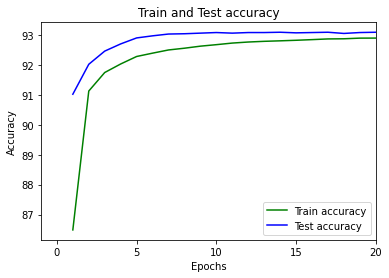

In [7]:
import matplotlib.pyplot as plt

epochs = range(1, 21)
plt.plot(epochs, history_tr, 'g', label='Train accuracy')
plt.plot(epochs, history_ts, 'b', label='Test accuracy')
plt.title('Train and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([-1, 20])
#plt.ylim([85, 95])
plt.xticks(np.linspace(0, 20, 5))
#plt.yticks(np.linspace(85, 95, 5))
plt.legend(loc='lower right')
plt.show()

### Build the confusion matrix :

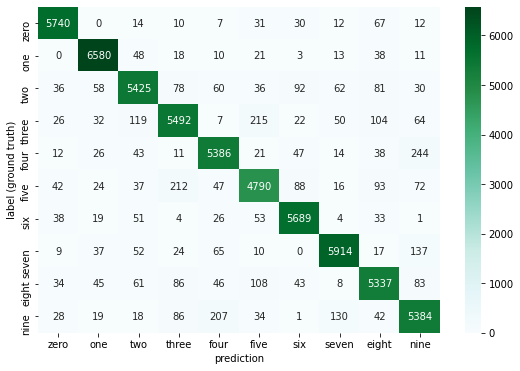

In [8]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Train
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true_tr, y_pred_tr)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

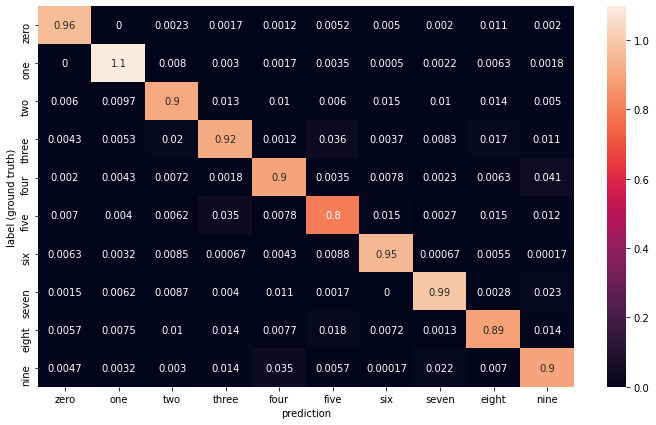

In [9]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true_tr, y_pred_tr)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

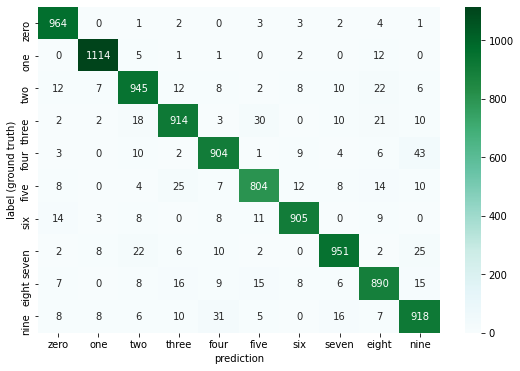

In [10]:
# Test
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

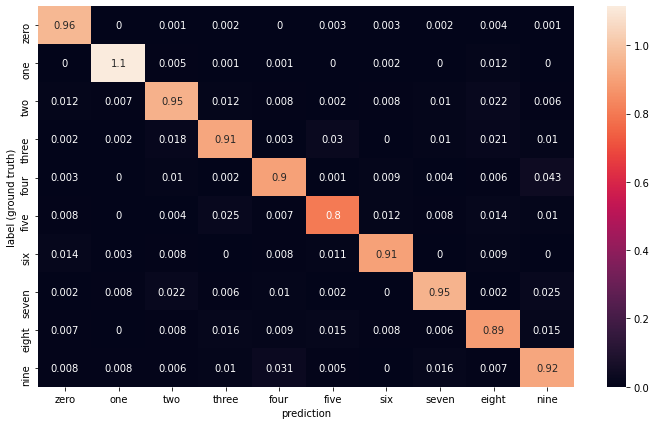

In [11]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

## Define a classification model taking the RBM hidden states as embbedings.

In [12]:
class EMB_RBM_Net(torch.nn.Module):
    def __init__(self, rbm, input_dim, output_dim):
        super(EMB_RBM_Net, self).__init__()
        self.rbm = rbm
        self.fl1 = torch.nn.Linear(input_dim, HIDDEN_UNITS)
        self.fl1.weight.data.copy_(torch.transpose(self.rbm.w, 0, 1))
        self.fl1.bias.data.copy_(self.rbm.hidden_b)
        self.fl2 = torch.nn.Linear(HIDDEN_UNITS, output_dim)

    def forward(self, x):
        x = self.fl1(x)
        x = F.sigmoid(x)
        x = self.fl2(x)

        return F.log_softmax(x, dim=1)

    def train(self, tr_loader, ts_loader, optimizer, clf, criterion, epochs=20):
        history_tr = []
        history_ts = []
        for epoch in range(epochs):
          correct_tr = 0
          total_tr = 0
          y_true_tr = []
          y_pred_tr = []
          for i, (batch_tr, labels_tr) in enumerate(tr_loader):
            batch_tr = Variable(batch_tr.view(-1, VISIBLE_UNITS))
            labels_tr = Variable(labels_tr)

            optimizer.zero_grad()
            outputs_tr = clf(batch_tr)
            loss_tr = criterion(outputs_tr, labels_tr)
            _, prediction_tr = torch.max(outputs_tr.data, 1)
            y_true_tr.extend(labels_tr)
            y_pred_tr.extend(prediction_tr)
            total_tr += labels_tr.size(0)
            correct_tr += (prediction_tr == labels_tr).sum()
            loss_tr.backward()
            optimizer.step()
          accuracy_tr = correct_tr / total_tr * 100
          history_tr.append(accuracy_tr.data)
          # calculate accuracy
          correct = 0
          total = 0
          y_true = []
          y_pred = []
          for batch, labels in ts_loader:
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            outputs = clf(batch)
            _, prediction = torch.max(outputs.data, 1)
            y_true.extend(labels)
            y_pred.extend(prediction)
            total += labels.size(0)
            correct += (prediction == labels).sum()
          accuracy = correct / total * 100
          history_ts.append(accuracy.data)
          print("Epoch : {0:2d} | loss : {1:.4f} | Train Accuracy: {2:.2f}  | Test Accuracy: {3:.2f}".format(epoch+1, loss_tr.item(), accuracy_tr, accuracy))
      
        return y_true_tr, y_pred_tr, y_true, y_pred, history_tr, history_ts

emb_rbm_Model = EMB_RBM_Net(rbm, VISIBLE_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(emb_rbm_Model.parameters(), lr=1e-3)

### Train the classifier :

In [13]:
y_true_tr,y_pred_tr,y_true,y_pred,history_tr,history_ts = emb_rbm_Model.train(tr_loader, ts_loader, optimizer, emb_rbm_Model, criterion)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch :  1 | loss : 0.0341 | Train Accuracy: 89.42  | Test Accuracy: 93.84
Epoch :  2 | loss : 0.0145 | Train Accuracy: 94.83  | Test Accuracy: 95.34
Epoch :  3 | loss : 0.0103 | Train Accuracy: 96.15  | Test Accuracy: 96.02
Epoch :  4 | loss : 0.0083 | Train Accuracy: 96.96  | Test Accuracy: 96.49
Epoch :  5 | loss : 0.0076 | Train Accuracy: 97.53  | Test Accuracy: 96.70
Epoch :  6 | loss : 0.0078 | Train Accuracy: 97.92  | Test Accuracy: 96.83
Epoch :  7 | loss : 0.0086 | Train Accuracy: 98.29  | Test Accuracy: 96.94
Epoch :  8 | loss : 0.0092 | Train Accuracy: 98.59  | Test Accuracy: 97.01
Epoch :  9 | loss : 0.0082 | Train Accuracy: 98.85  | Test Accuracy: 97.06
Epoch : 10 | loss : 0.0062 | Train Accuracy: 99.05  | Test Accuracy: 97.06
Epoch : 11 | loss : 0.0045 | Train Accuracy: 99.24  | Test Accuracy: 97.09
Epoch : 12 | loss : 0.0035 | Train Accuracy: 99.40  | Test Accuracy: 97.11
Epoch : 13 | loss : 0.0028 | Train Accuracy: 99.50  | Test Accuracy: 97.19
Epoch : 14 | loss : 0.002

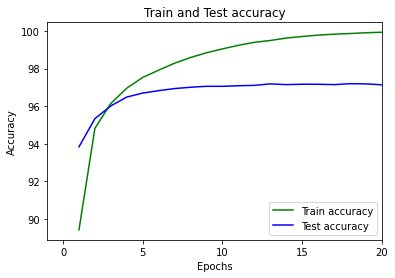

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, 21)
plt.plot(epochs, history_tr, 'g', label='Train accuracy')
plt.plot(epochs, history_ts, 'b', label='Test accuracy')
plt.title('Train and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([-1, 20])
#plt.ylim([85, 95])
plt.xticks(np.linspace(0, 20, 5))
#plt.yticks(np.linspace(85, 95, 5))
plt.legend(loc='lower right')
plt.show()

### Check the pretrained RBM layer weights to make sure it is updated :

In [15]:
emb_rbm_Model.fl1.weight.data == torch.transpose(rbm.w, 0, 1)

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [16]:
(emb_rbm_Model.fl1.weight.data == torch.transpose(rbm.w, 0, 1)).all()

tensor(False)

### Build the confusion matrix :

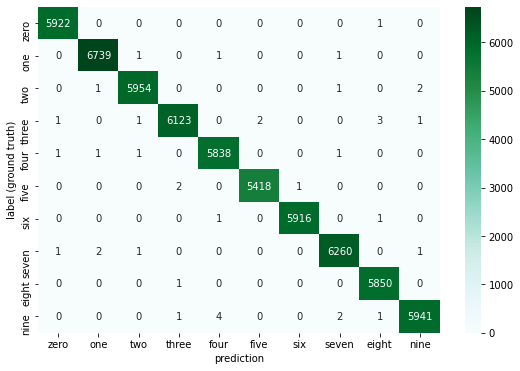

In [17]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Train
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true_tr, y_pred_tr)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

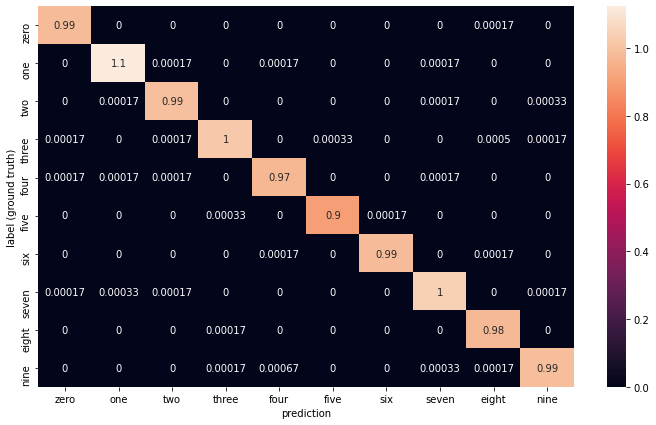

In [18]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true_tr, y_pred_tr)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

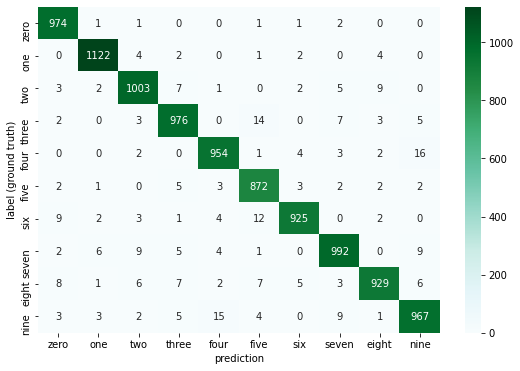

In [19]:
# Test
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

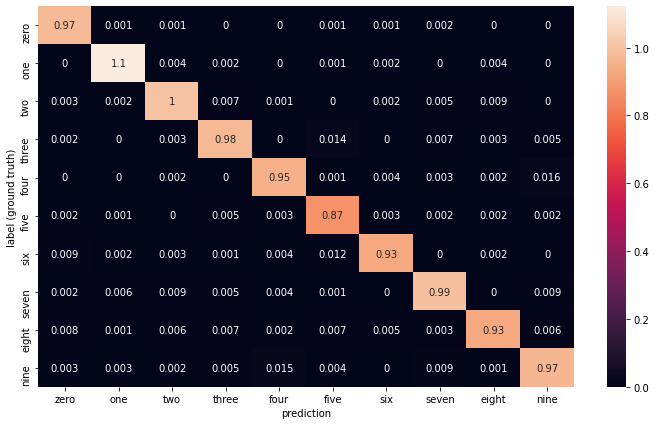

In [20]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

# **Deep Belief network(DBN)** :

## Define DBN model:

In [21]:
class DBN(nn.Module):
  def __init__(self, n_visible=28*28, n_hiddens=[HIDDEN_UNITS, HIDDEN_UNITS], k=1):
    super(DBN, self).__init__()
    
    self.n_layers = len(n_hiddens)
    self.rbm_layers = []
  
    # creating different RBM layers
    for i in range(self.n_layers):
      n_input = 0;
      if i == 0:
        n_input = n_visible
      else:
        n_input = n_hiddens[i-1]
      rbm = RBM(n_input, n_hiddens[i], k)
      self.rbm_layers.append(rbm)

  def forward(self, input):
    '''
    running the forward pass
    '''
    visible = input 
    for i in range(len(self.rbm_layers)):
      hidden_p, hidden = self.rbm_layers[i].v2h(visible)
      visible = hidden_p
    return hidden_p, hidden

  def reconstruct(self, input):
    '''
    go till the final layer and then reconstruct
    '''
    # visible_p = input

    # for i in range(len(self.rbm_layers)):
    #   hidden_p, h = self.rbm_layers[i].v2h(visible_p)
    #   visible_p = hidden_p
    hidden_p, h = self.forward(input)
    hidden = h

    for i in range(len(self.rbm_layers)-1,-1,-1):
      recon_visible_p, recon_visible = self.rbm_layers[i].h2v(hidden)
      hidden = recon_visible
    return recon_visible_p, recon_visible

  def train(self,  train_data, train_labels, n_epochs=EPOCHS, batch_size=16, debug=True):
    verbose = 1
    transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
    train_data = torch.stack([transform(data) for data in train_data]).squeeze()
    tmp = train_data
    for i in range(len(self.rbm_layers)):
      if debug:
        print("-"*40)
        print("Training rbm layer number {}".format(i+1))
      
      # Transform raw input data for rbm_layers 0:
      
      if i == len(self.rbm_layers)-1:
        verbose = 0

      tensor_data = tmp.type(torch.FloatTensor)
      tensor_label = train_labels.type(torch.FloatTensor)
      dataset = torch.utils.data.TensorDataset(tensor_data, tensor_label)
      data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

      if not debug:
        verbose = 0
      self.rbm_layers[i].train(n_epochs, data_loader, verbose)
      visible = tensor_data.view((tensor_data.shape[0], -1))
      hidden_p, _ = self.rbm_layers[i].v2h(visible)
      tmp = hidden_p
      
      # Reconstruct Error for last layer
      if i == len(self.rbm_layers)-1:
        train_data = train_data.view((train_data.shape[0], -1))
        recon_visible_p, recon_visible = self.reconstruct(train_data)
        err = torch.sum((train_data - recon_visible_p)**2)
        if debug:
          print("Reconstruct Error : %.4f" % err)
    return

## Train DBN

In [22]:
dbn = DBN()
dbn.train(tr_dataset.train_data, tr_dataset.train_labels)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


----------------------------------------
Training rbm layer number 1
Epoch Error (epoch=1): 1014134.9375
Epoch Error (epoch=2): 772029.3750
Epoch Error (epoch=3): 729358.6875
Epoch Error (epoch=4): 706338.1250
Epoch Error (epoch=5): 691018.6875
Epoch Error (epoch=6): 682196.1250
Epoch Error (epoch=7): 676356.1250
Epoch Error (epoch=8): 672070.9375
Epoch Error (epoch=9): 668983.5000
Epoch Error (epoch=10): 666169.3125
Epoch Error (epoch=11): 664221.3750
Epoch Error (epoch=12): 661825.7500
Epoch Error (epoch=13): 660798.1875
Epoch Error (epoch=14): 659133.9375
Epoch Error (epoch=15): 657827.5625
Epoch Error (epoch=16): 655654.7500
Epoch Error (epoch=17): 655126.3125
Epoch Error (epoch=18): 653762.4375
Epoch Error (epoch=19): 653211.3750
Epoch Error (epoch=20): 653107.1875
Epoch Error (epoch=21): 652335.2500
Epoch Error (epoch=22): 652049.3750
Epoch Error (epoch=23): 651237.5625
Epoch Error (epoch=24): 650779.1250
Epoch Error (epoch=25): 649703.0000
Epoch Error (epoch=26): 648448.3125
Epo

## Visualising DBN layer :

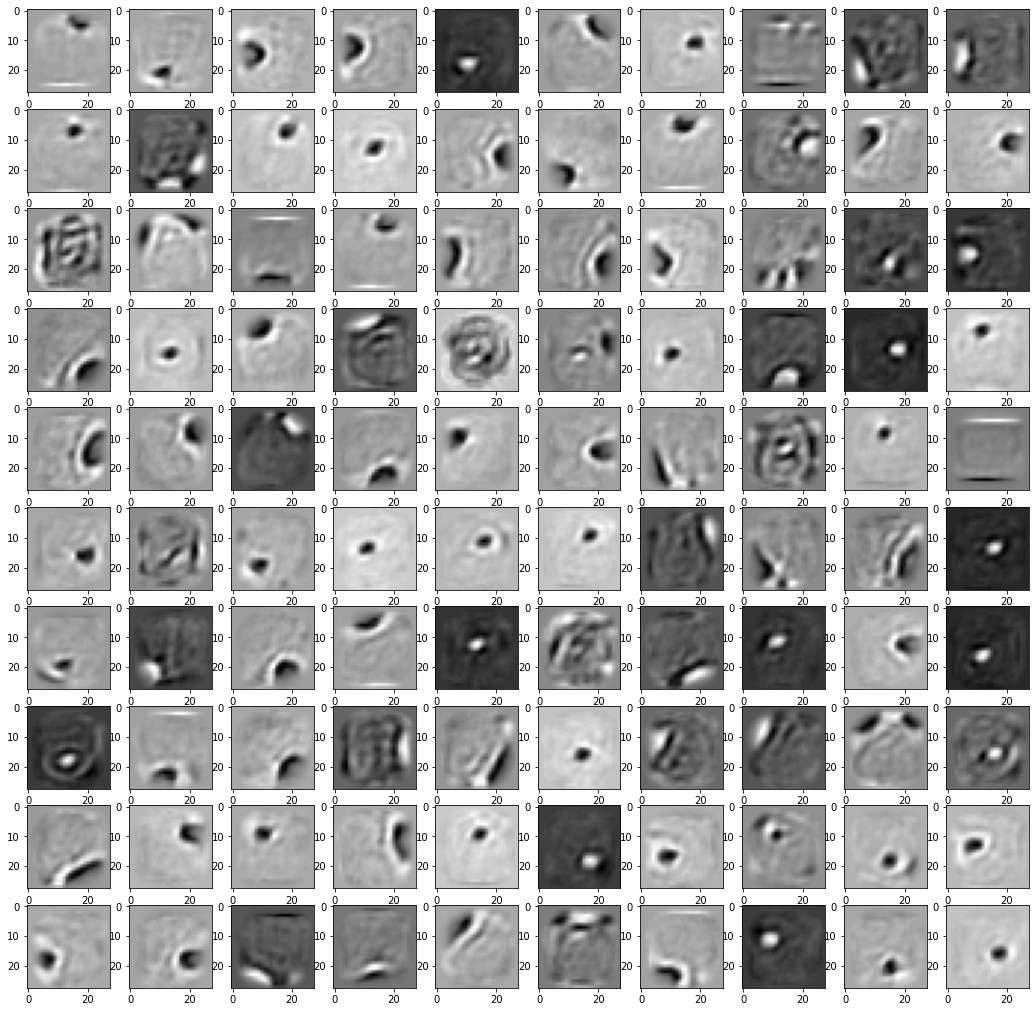

In [23]:
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

# visualising layer 1
learned_weights = dbn.rbm_layers[0].w.transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(18,18))
for i in range(100): 
    sub = fig.add_subplot(10, 10, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

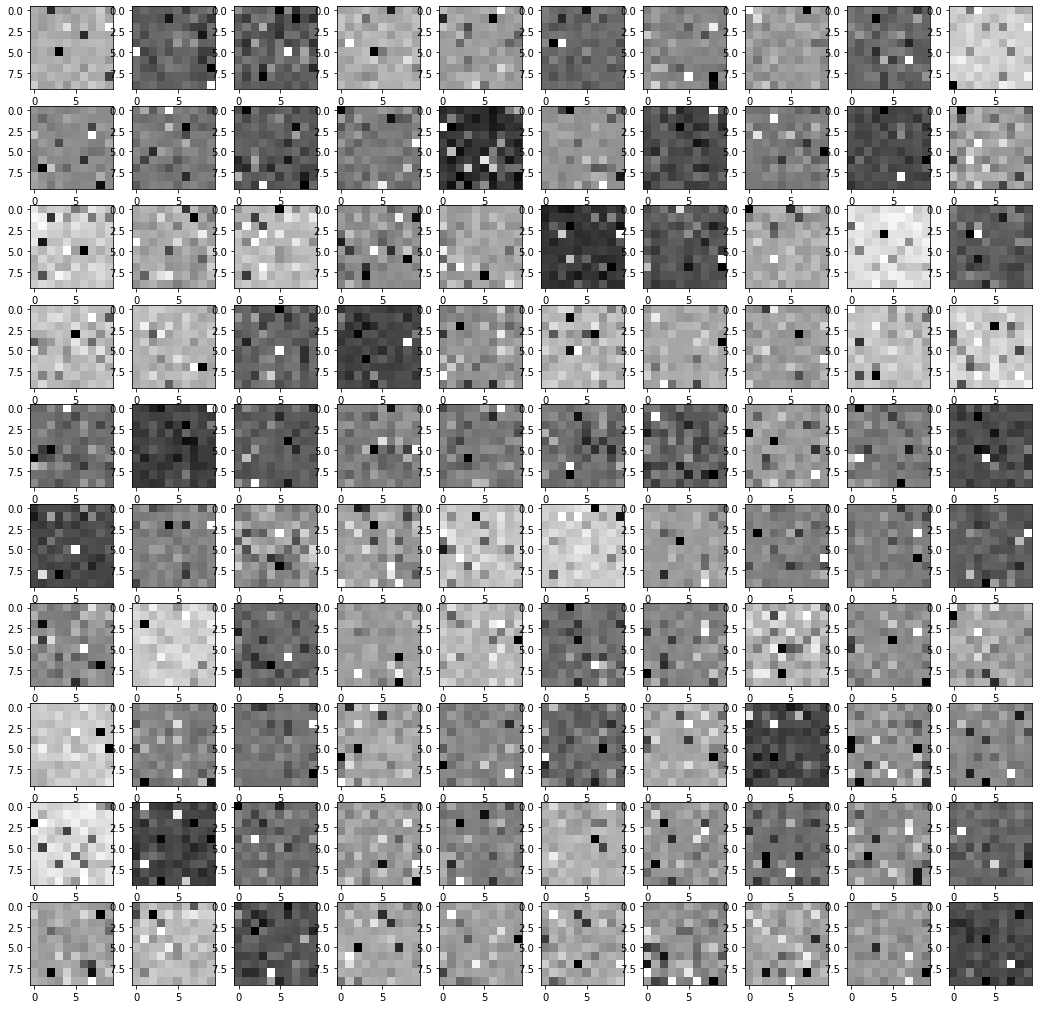

In [24]:
# visualising layer 2
learned_weights = dbn.rbm_layers[1].w.transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(18,18))
for i in range(100): 
    sub = fig.add_subplot(10, 10, i+1)
    sub.imshow(learned_weights[i,:].reshape((10,10)), cmap=plt.cm.gray)
plt.show()

## Train a classification model by placing a softmax layer after the DBN

In [25]:
class DBN_Net(torch.nn.Module):
    def __init__(self, dbn, input_dim, output_dim):
        super(DBN_Net, self).__init__()
        self.dbn = dbn
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x, _ = self.dbn.forward(x)
        x = self.linear(x)

        return F.log_softmax(x, dim=1)

    def train(self, tr_loader, ts_loader, optimizer, clf, criterion, epochs=20):
        history_tr = []
        history_ts = []
        for epoch in range(epochs):
          correct_tr = 0
          total_tr = 0
          y_true_tr = []
          y_pred_tr = []
          for i, (batch_tr, labels_tr) in enumerate(tr_loader):
            batch_tr = Variable(batch_tr.view(-1, VISIBLE_UNITS))
            labels_tr = Variable(labels_tr)

            optimizer.zero_grad()
            outputs_tr = clf(batch_tr)
            loss_tr = criterion(outputs_tr, labels_tr)
            _, prediction_tr = torch.max(outputs_tr.data, 1)
            y_true_tr.extend(labels_tr)
            y_pred_tr.extend(prediction_tr)
            total_tr += labels_tr.size(0)
            correct_tr += (prediction_tr == labels_tr).sum()
            loss_tr.backward()
            optimizer.step()
          accuracy_tr = correct_tr / total_tr * 100
          history_tr.append(accuracy_tr.data)
          # calculate accuracy
          correct = 0
          total = 0
          y_true = []
          y_pred = []
          for batch, labels in ts_loader:
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            outputs = clf(batch)
            _, prediction = torch.max(outputs.data, 1)
            y_true.extend(labels)
            y_pred.extend(prediction)
            total += labels.size(0)
            correct += (prediction == labels).sum()
          accuracy = correct / total * 100
          history_ts.append(accuracy.data)
          print("Epoch : {0:2d} | loss : {1:.4f} | Train Accuracy: {2:.2f}  | Test Accuracy: {3:.2f}".format(epoch+1, loss_tr.item(), accuracy_tr, accuracy))
      
        return y_true_tr, y_pred_tr, y_true, y_pred, history_tr, history_ts

dbn_Model = DBN_Net(dbn, HIDDEN_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(dbn_Model.parameters(), lr=1e-3)

In [26]:
y_true_tr,y_pred_tr,y_true,y_pred,history_tr,history_ts = dbn_Model.train(tr_loader, ts_loader, optimizer, dbn_Model, criterion)

Epoch :  1 | loss : 0.1021 | Train Accuracy: 87.41  | Test Accuracy: 91.07
Epoch :  2 | loss : 0.0658 | Train Accuracy: 91.25  | Test Accuracy: 92.31
Epoch :  3 | loss : 0.0556 | Train Accuracy: 91.97  | Test Accuracy: 92.65
Epoch :  4 | loss : 0.0512 | Train Accuracy: 92.25  | Test Accuracy: 92.82
Epoch :  5 | loss : 0.0488 | Train Accuracy: 92.52  | Test Accuracy: 93.00
Epoch :  6 | loss : 0.0474 | Train Accuracy: 92.71  | Test Accuracy: 93.17
Epoch :  7 | loss : 0.0464 | Train Accuracy: 92.81  | Test Accuracy: 93.26
Epoch :  8 | loss : 0.0458 | Train Accuracy: 92.89  | Test Accuracy: 93.34
Epoch :  9 | loss : 0.0453 | Train Accuracy: 92.96  | Test Accuracy: 93.29
Epoch : 10 | loss : 0.0450 | Train Accuracy: 93.04  | Test Accuracy: 93.36
Epoch : 11 | loss : 0.0447 | Train Accuracy: 93.08  | Test Accuracy: 93.41
Epoch : 12 | loss : 0.0446 | Train Accuracy: 93.11  | Test Accuracy: 93.41
Epoch : 13 | loss : 0.0444 | Train Accuracy: 93.14  | Test Accuracy: 93.42
Epoch : 14 | loss : 0.044

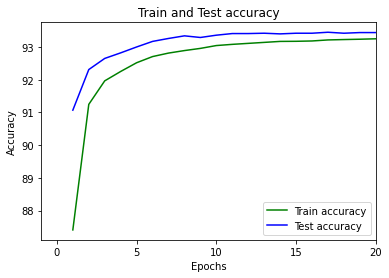

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, 21)
plt.plot(epochs, history_tr, 'g', label='Train accuracy')
plt.plot(epochs, history_ts, 'b', label='Test accuracy')
plt.title('Train and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([-1, 20])
#plt.ylim([85, 95])
plt.xticks(np.linspace(0, 20, 5))
#plt.yticks(np.linspace(85, 95, 5))
plt.legend(loc='lower right')
plt.show()

### Build the confusion matrix :

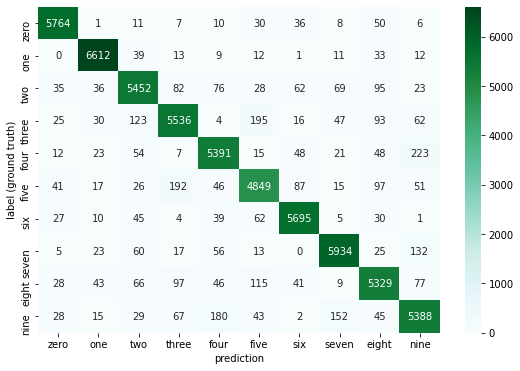

In [28]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Train
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true_tr, y_pred_tr)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

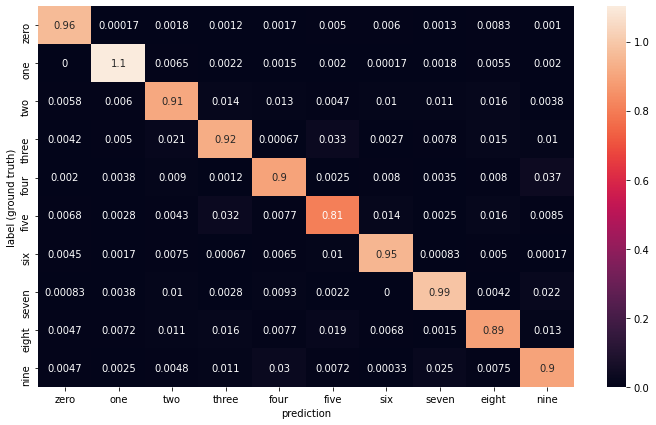

In [29]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true_tr, y_pred_tr)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

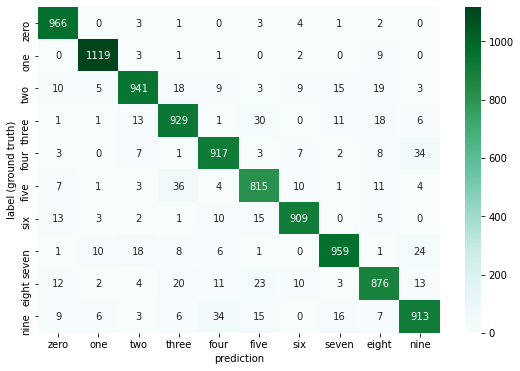

In [30]:
# Test
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

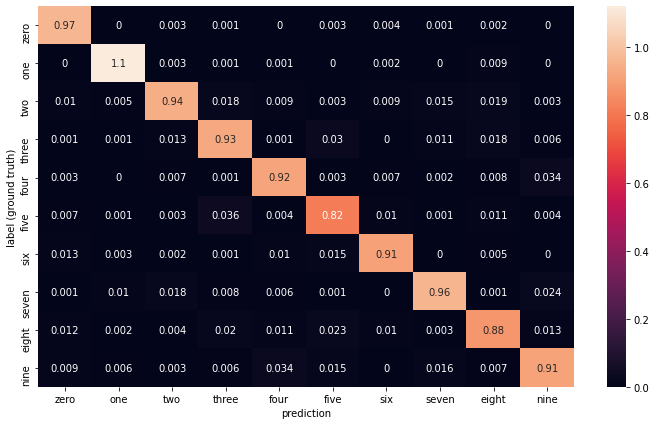

In [31]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

## Train a classification model taking the DBN hidden states as embbedings.

In [32]:
class EMB_DBN_Net(torch.nn.Module):
    def __init__(self, dbn, input_dim, output_dim):
        super(EMB_DBN_Net, self).__init__()
        self.dbn = dbn
        self.fl1 = torch.nn.Linear(input_dim, HIDDEN_UNITS)
        self.fl1.weight.data.copy_(torch.transpose(self.dbn.rbm_layers[0].w, 0, 1))
        self.fl1.bias.data.copy_(self.dbn.rbm_layers[0].hidden_b)
        self.fl2 = torch.nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS)
        self.fl2.weight.data.copy_(torch.transpose(self.dbn.rbm_layers[1].w, 0, 1))
        self.fl2.bias.data.copy_(self.dbn.rbm_layers[1].hidden_b)
        self.fl3 = torch.nn.Linear(HIDDEN_UNITS, output_dim)

    def forward(self, x):
        x = self.fl1(x)
        x = F.sigmoid(x)
        x = self.fl2(x)
        x = F.sigmoid(x)
        x = self.fl3(x)

        return F.log_softmax(x, dim=1)

    def train(self, tr_loader, ts_loader, optimizer, clf, criterion, epochs=20):
        history_tr = []
        history_ts = []
        for epoch in range(epochs):
          correct_tr = 0
          total_tr = 0
          y_true_tr = []
          y_pred_tr = []
          for i, (batch_tr, labels_tr) in enumerate(tr_loader):
            batch_tr = Variable(batch_tr.view(-1, VISIBLE_UNITS))
            labels_tr = Variable(labels_tr)

            optimizer.zero_grad()
            outputs_tr = clf(batch_tr)
            loss_tr = criterion(outputs_tr, labels_tr)
            _, prediction_tr = torch.max(outputs_tr.data, 1)
            y_true_tr.extend(labels_tr)
            y_pred_tr.extend(prediction_tr)
            total_tr += labels_tr.size(0)
            correct_tr += (prediction_tr == labels_tr).sum()
            loss_tr.backward()
            optimizer.step()
          accuracy_tr = correct_tr / total_tr * 100
          history_tr.append(accuracy_tr.data)
          # calculate accuracy
          correct = 0
          total = 0
          y_true = []
          y_pred = []
          for batch, labels in ts_loader:
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            outputs = clf(batch)
            _, prediction = torch.max(outputs.data, 1)
            y_true.extend(labels)
            y_pred.extend(prediction)
            total += labels.size(0)
            correct += (prediction == labels).sum()
          accuracy = correct / total * 100
          history_ts.append(accuracy.data)
          print("Epoch : {0:2d} | loss : {1:.4f} | Train Accuracy: {2:.2f}  | Test Accuracy: {3:.2f}".format(epoch+1, loss_tr.item(), accuracy_tr, accuracy))
      
        return y_true_tr, y_pred_tr, y_true, y_pred, history_tr, history_ts

emb_dbn_model = EMB_DBN_Net(dbn, VISIBLE_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(emb_dbn_model.parameters(), lr=1e-3)

In [33]:
y_true_tr,y_pred_tr,y_true,y_pred,history_tr,history_ts = emb_dbn_model.train(tr_loader, ts_loader, optimizer, emb_dbn_model, criterion)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch :  1 | loss : 0.0221 | Train Accuracy: 90.76  | Test Accuracy: 94.89
Epoch :  2 | loss : 0.0094 | Train Accuracy: 95.65  | Test Accuracy: 95.97
Epoch :  3 | loss : 0.0061 | Train Accuracy: 97.00  | Test Accuracy: 96.63
Epoch :  4 | loss : 0.0050 | Train Accuracy: 97.76  | Test Accuracy: 96.80
Epoch :  5 | loss : 0.0038 | Train Accuracy: 98.37  | Test Accuracy: 96.88
Epoch :  6 | loss : 0.0032 | Train Accuracy: 98.80  | Test Accuracy: 97.00
Epoch :  7 | loss : 0.0027 | Train Accuracy: 99.10  | Test Accuracy: 96.99
Epoch :  8 | loss : 0.0019 | Train Accuracy: 99.36  | Test Accuracy: 96.96
Epoch :  9 | loss : 0.0014 | Train Accuracy: 99.57  | Test Accuracy: 97.09
Epoch : 10 | loss : 0.0010 | Train Accuracy: 99.71  | Test Accuracy: 97.19
Epoch : 11 | loss : 0.0006 | Train Accuracy: 99.79  | Test Accuracy: 97.19
Epoch : 12 | loss : 0.0004 | Train Accuracy: 99.87  | Test Accuracy: 97.20
Epoch : 13 | loss : 0.0003 | Train Accuracy: 99.92  | Test Accuracy: 97.15
Epoch : 14 | loss : 0.000

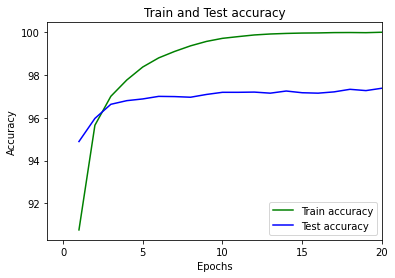

In [34]:
import matplotlib.pyplot as plt

epochs = range(1, 21)
plt.plot(epochs, history_tr, 'g', label='Train accuracy')
plt.plot(epochs, history_ts, 'b', label='Test accuracy')
plt.title('Train and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([-1, 20])
#plt.ylim([85, 95])
plt.xticks(np.linspace(0, 20, 5))
#plt.yticks(np.linspace(85, 95, 5))
plt.legend(loc='lower right')
plt.show()

### Build the confusion matrix :

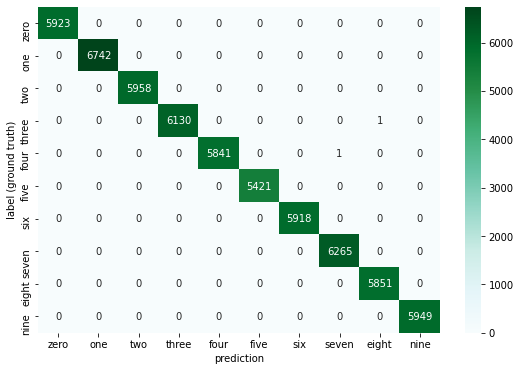

In [35]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Train
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true_tr, y_pred_tr)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

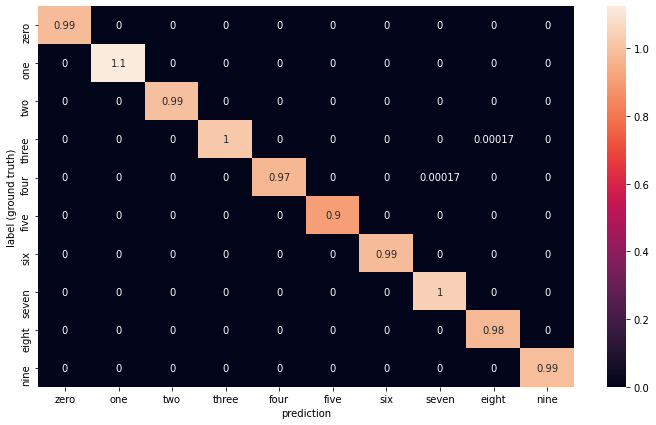

In [36]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true_tr, y_pred_tr)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

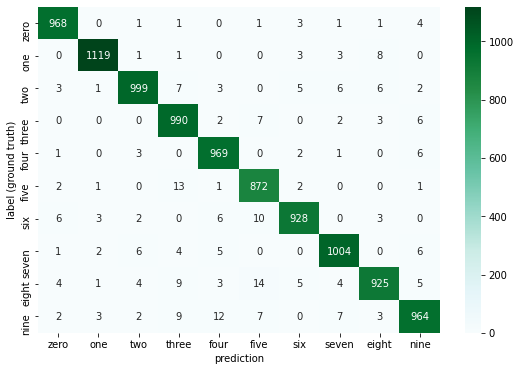

In [37]:
# Test
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

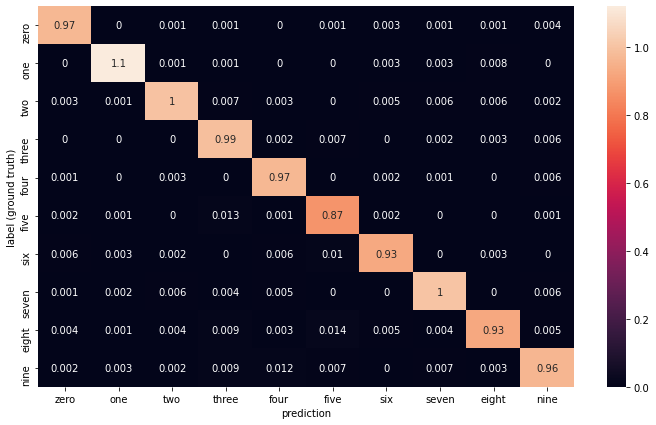

In [38]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

# **Plot the results**

In [39]:
def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

In [40]:
examples = enumerate(ts_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [41]:
recon_data_p_RBM, recon_data_RBM = rbm.h2v(rbm.v2h(example_data.view(-1, VISIBLE_UNITS))[0])

In [42]:
recon_data_p_DBN, recon_data_DBN = dbn.reconstruct(example_data.view(-1, VISIBLE_UNITS))
recon_data_p_DBN1, recon_data_DBN1 = dbn.rbm_layers[0].h2v(dbn.rbm_layers[0].v2h(example_data.view(-1, VISIBLE_UNITS))[0])

### plot raw last batch:

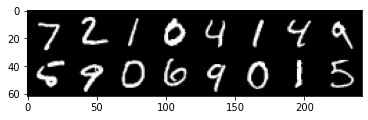

In [43]:
show_adn_save("real",make_grid(example_data.view(example_data.shape[0],1,28,28).data))

### plot reconstructed last batch with propbalitys :

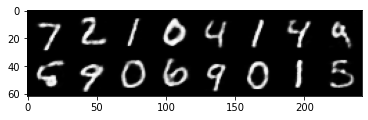

In [44]:
show_adn_save("generate",make_grid(recon_data_p_RBM.view(recon_data_p_RBM.shape[0],1,28,28).data))

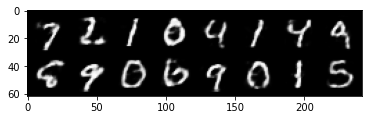

In [45]:
show_adn_save("generate",make_grid(recon_data_p_DBN.view(recon_data_p_DBN.shape[0],1,28,28).data))

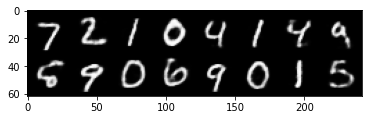

In [46]:
show_adn_save("generate",make_grid(recon_data_p_DBN1.view(recon_data_p_DBN1.shape[0],1,28,28).data))

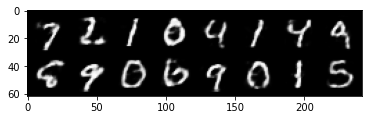

In [47]:
show_adn_save("generate",make_grid(recon_data_p_DBN.view(recon_data_p_DBN.shape[0],1,28,28).data))

### plot reconstructed last batch with sampled data :

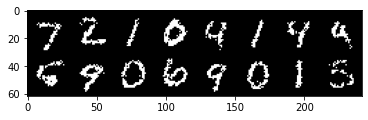

In [48]:
show_adn_save("generate",make_grid(recon_data_RBM.view(recon_data_RBM.shape[0],1,28,28).data))

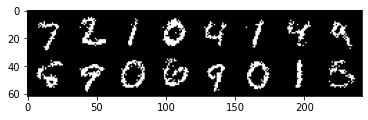

In [49]:
show_adn_save("generate",make_grid(recon_data_DBN1.view(recon_data_DBN1.shape[0],1,28,28).data))

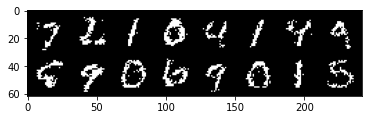

In [50]:
show_adn_save("generate",make_grid(recon_data_DBN.view(recon_data_DBN.shape[0],1,28,28).data))

### plot the reconstruced first batch of test dataset :

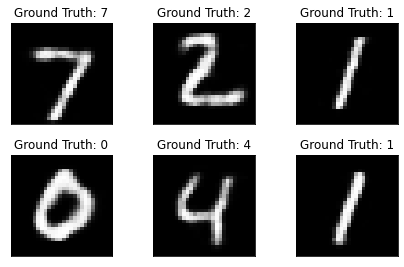

In [51]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(recon_data_p_RBM.view(recon_data_p_RBM.shape[0],1,28,28)[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

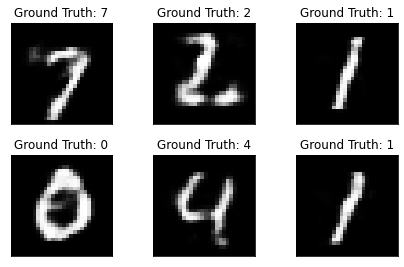

In [52]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(recon_data_p_DBN.view(recon_data_p_DBN.shape[0],1,28,28)[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## Try to apply affine transformation to the raw img, in result the classifier will make a wrong prediction on the new img: 

In [53]:
recon_data_p_RBM, recon_data_RBM = rbm.h2v(rbm.v2h(example_data[1].view(-1, VISIBLE_UNITS))[0])
recon_data_p_DBN, recon_data_DBN = dbn.reconstruct(example_data[1].view(-1, VISIBLE_UNITS))

In [54]:
recon_data_p_DBN1, recon_data_DBN1 = dbn.rbm_layers[0].h2v(dbn.rbm_layers[0].v2h(example_data[1].view(-1, VISIBLE_UNITS))[0])
recon_data_p_DBN2, recon_data_DBN2 = dbn.rbm_layers[0].h2v(dbn.rbm_layers[1].h2v(dbn.rbm_layers[1].v2h(dbn.rbm_layers[0].v2h(example_data[1].view(-1, VISIBLE_UNITS))[0])[0])[1])

Text(0.5, 1.0, 'DBN, Ground Truth: 2')

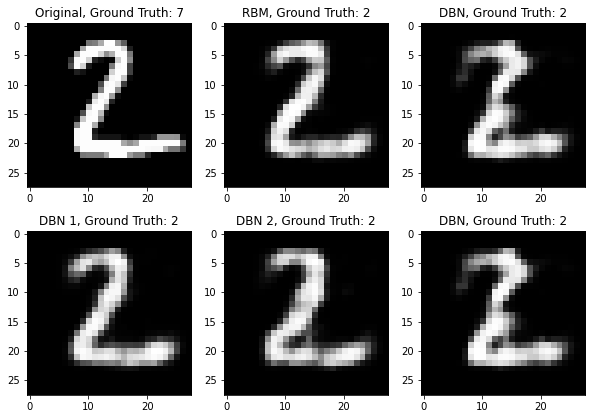

In [55]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplot(2,3,1)
plt.imshow(example_data[1][0], cmap='gray', interpolation='none')
plt.title("Original, Ground Truth: {}".format(example_targets[0]))
plt.subplot(2,3,2)
plt.imshow(recon_data_p_RBM.view((28,28)), cmap='gray', interpolation='none')
plt.title("RBM, Ground Truth: {}".format(example_targets[1]))
plt.subplot(2,3,3)
plt.imshow(recon_data_p_DBN.view((28,28)), cmap='gray', interpolation='none')
plt.title("DBN, Ground Truth: {}".format(example_targets[1]))
plt.subplot(2,3,4)
plt.imshow(recon_data_p_DBN1.view((28,28)), cmap='gray', interpolation='none')
plt.title("DBN 1, Ground Truth: {}".format(example_targets[1]))
plt.subplot(2,3,5)
plt.imshow(recon_data_p_DBN2.view((28,28)), cmap='gray', interpolation='none')
plt.title("DBN 2, Ground Truth: {}".format(example_targets[1]))
plt.subplot(2,3,6)
plt.imshow(recon_data_p_DBN.view((28,28)), cmap='gray', interpolation='none')
plt.title("DBN, Ground Truth: {}".format(example_targets[1]))

### Define a composed transforms :

In [56]:
compose = transforms.Compose([transforms.RandomAffine(10, translate = (0.02,0.09)),transforms.Resize((28,28))])

### Apply affine transforms :

Text(0.5, 1.0, 'Ground Truth: 2')

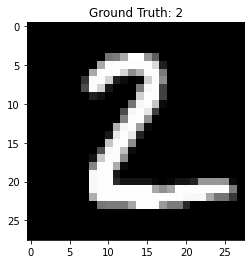

In [57]:
test = example_data[1]
compose(test).shape
plt.imshow(compose(test)[0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[1]))

### Check the prediction :

In [58]:
batch = Variable(compose(test).view(-1, VISIBLE_UNITS))
outputs = emb_dbn_model(batch)
_, prediction = torch.max(outputs.data, 1)
prediction

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([2])

### reconstruct the new img by RBM

In [59]:
recon_data_p_RBM, recon_data_RBM = rbm.h2v(rbm.v2h(compose(test)[0].view(-1, VISIBLE_UNITS))[0])
recon_data_p_DBN, recon_data_DBN = dbn.reconstruct(compose(test)[0].view(-1, VISIBLE_UNITS))

### plot the reconstructed new img

Text(0.5, 1.0, 'Ground Truth: 2 but Prediction: 2')

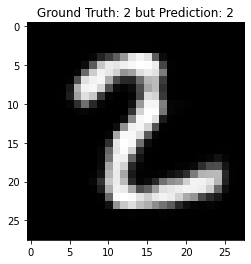

In [60]:
plt.imshow(recon_data_p_RBM.view(recon_data_p_RBM.shape[0],1,28,28)[0][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {} but Prediction: {}".format(example_targets[1],*(prediction.numpy())))

Text(0.5, 1.0, 'Ground Truth: 2 but Prediction: 2')

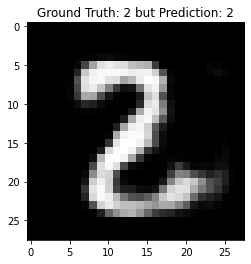

In [61]:
plt.imshow(recon_data_p_DBN.view(recon_data_p_DBN.shape[0],1,28,28)[0][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {} but Prediction: {}".format(example_targets[1],*(prediction.numpy())))

# **Gibbs sampling (from random initial status) on Particular mnist**

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
from PIL import Image

for number in range(10):
  # A number between 0 and 10.
  print("-"*60)
  print("Training dbn for number {}".format(number))
  print("-"*60)

  particular_mnist = []
  limit = tr_dataset.train_data.shape[0]

  for i in range(limit):
      if(tr_dataset.train_labels[i] == number):
          particular_mnist.append(tr_dataset.train_data[i].numpy())

  len(particular_mnist)
  train_data = torch.stack([torch.Tensor(i) for i in particular_mnist])
  train_label = torch.stack([torch.Tensor(number) for i in range(len(particular_mnist))])
  dbn_p = DBN()
  dbn_p.train(train_data,train_label,debug=False)
  

  vi = torch.randn(784)
  for i in range(250):
    #hip, hi = dbn_p.rbm_layers[0].v2h(vi)
    #vip, vi = dbn_p.rbm_layers[0].h2v(hi)
    vip, vi = dbn_p.reconstruct(vi)
    if i > 199: 
      p = vip.view((28,28))
      img = p.data.numpy()
      #plt.imshow(img, cmap='gray')
      #plt.show()
      fname = "/content/test/{}.png".format(i-200)
      plt.imsave(fname, img, cmap='gray')

  images = []
  for i in range(50):
    fname = "/content/test/{}.png".format(i)
    img = Image.open(fname)
    images.append(img)
  path = "/content/drive/MyDrive/gifs/dbn/{}.gif".format(number)
  images[0].save(path, save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)
  print("-"*60)
  print("Done, gif image saved in {}".format(path))
  print("-"*60)

------------------------------------------------------------
Training dbn for number 0
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/0.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 1
------------------------------------------------------------
------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/1.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 2
------------------------------------------------------------
------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/2.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 3
------------------------------------------------------------
-

# **Reconstruct the uploaded images**:

In [64]:
imgdir = "/content/drive/MyDrive/test_images"
ts_dataset1 = datasets.ImageFolder(imgdir, transform= transforms.Compose(
        [transforms.ToTensor(), transforms.Grayscale(num_output_channels=1), transforms.Resize([28,28])]))
ts_loader1 = torch.utils.data.DataLoader(ts_dataset1, batch_size=1)

examples1 = enumerate(ts_loader1)
batch_idx1, (example_data1, example_targets1) = next(examples1)
img = example_data1[0][0]
img = 1 - img

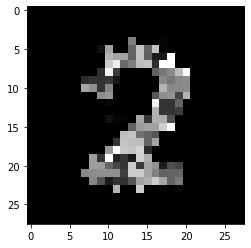

The reconstructed image


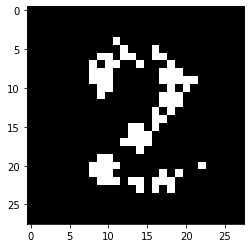

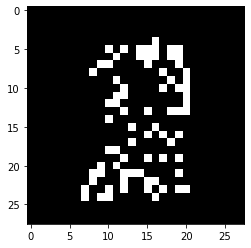

In [65]:
_,reconstructed_img_rbm= dbn.rbm_layers[0].h2v(dbn.rbm_layers[0].v2h(img.view(-1, VISIBLE_UNITS))[0])
_,reconstructed_img_dbn= dbn_p.reconstruct(img.view(1,-1))
reconstructed_img_rbm = reconstructed_img_rbm.view((28,28))
reconstructed_img_dbn = reconstructed_img_dbn.view((28,28))
plt.imshow(img , cmap = 'gray')
plt.show()
print("The reconstructed image")
plt.imshow(reconstructed_img_rbm , cmap = 'gray')
plt.show()
plt.imshow(reconstructed_img_dbn , cmap = 'gray')
plt.show()

In [66]:
batch_idx1, (example_data1, example_targets1) = next(examples1)
img = example_data1[0][0]
img = 1 - img

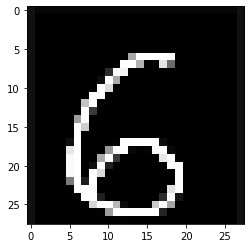

The reconstructed image


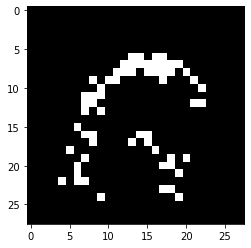

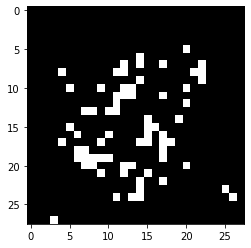

In [67]:
_,reconstructed_img_rbm= dbn.rbm_layers[0].h2v(dbn.rbm_layers[0].v2h(img.view(-1, VISIBLE_UNITS))[0])
_,reconstructed_img_dbn= dbn_p.reconstruct(img.view(1,-1))
reconstructed_img_rbm = reconstructed_img_rbm.view((28,28))
reconstructed_img_dbn = reconstructed_img_dbn.view((28,28))
plt.imshow(img , cmap = 'gray')
plt.show()
print("The reconstructed image")
plt.imshow(reconstructed_img_rbm , cmap = 'gray')
plt.show()
plt.imshow(reconstructed_img_dbn , cmap = 'gray')
plt.show()